# Exploring with Titanic Survivors
### By Herman Li

We have a data of 891 of 2224 passengers on the Titanic and we are here to find out what factors may affect passengers survival.  
With the data analysis below, we shall be able to label what kinds of people are most likely to survive.

Questions that we are interested in:  
What factors make passengers more or less likely to survive?  
Do more expensive tickets imply anything?  
Is it safer to travel alone?  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [2]:
### Importing data
data = pd.read_csv('C://Users/Herman Li/Dropbox/Ucad/002/titanic-data.csv')

## Game Plan
(i) Filling missing data   
(ii) Data Cleaning / Wrangling   
(iii) Exploring data   
(iv) Data visualization  
(v) Statistical Inference  
(vi) Conclusion


## (i) FIlling missing data

### Is the data complete? How shall we fill the missing data?

First start checking the completeness of the data.  
We have 'Cabin' missing more than 75 percent of the data.  
'Age' has a few missing that will be addressed later.  
'Embarked' has two missing inputs which can be simply filled.

In [3]:
print data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


We drop 'cabin' for the huge amount of missing values and the likeliness that it has little impact.
'Ticket' is dropped for the lack of correlation.

In [4]:
data = data.drop(['Ticket','Cabin'],axis = 1)

### Filling 'Embarked'

Then, we start completing the data by filling the missing values 'Embarked'.  
With 'Embarked' there are only 2 missing values, hence we can fill it with the mode for simplicity.  
Missing ones being people with 'PassengerId' = 62  & 830.

In [5]:
#data.set_index('PassengerId',inplace = True)

In [6]:
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [7]:
data['Embarked'].fillna('S', inplace = True)
print data[((data.PassengerId == 62) | (data.PassengerId == 830))]

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Fare Embarked  
61   female  38.0      0      0  80.0        S  
829  female  62.0      0      0  80.0        S  


### Filling 'Age'

We predict the 'Age' by the creating a list of guesses of random integers within 1 std away from the mean.  

In [8]:
data['prevAge'] = data['Age']

age_mean = data['Age'].mean()
age_std = data['Age'].std()
age_nan_count = data['Age'].isnull().sum()

age_guess_list = np.random.randint(age_mean - age_std, age_mean + age_std, size = age_nan_count)
data.loc[np.isnan(data['Age']),'Age'] = age_guess_list
data['Age'] = data['Age'].astype(int)

### Are the predicted ages appropiate?

To see if the guesses do not affect the original data too much, we can use graph to see whether the shape of the distribution has changed.  

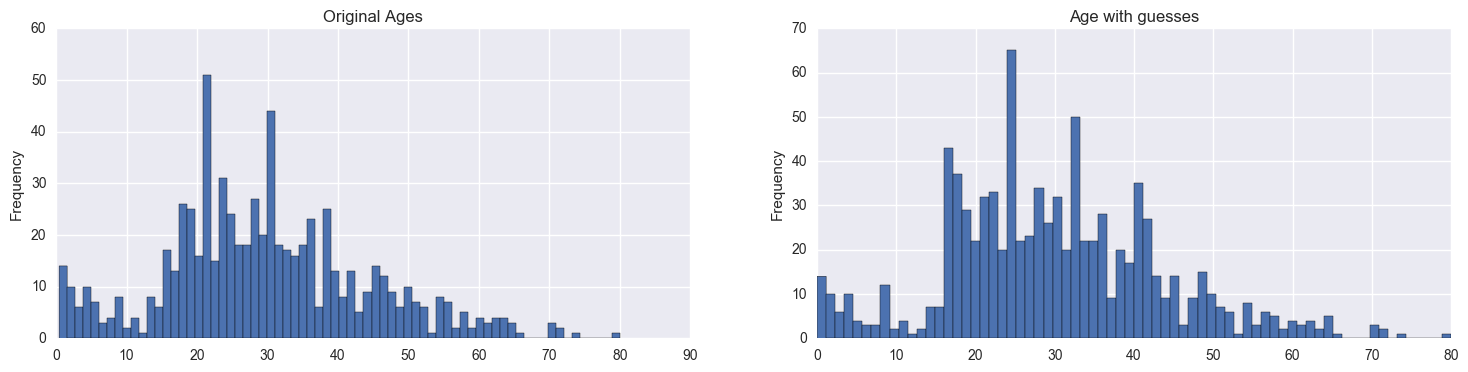

In [9]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(18,4))
ax1.set_title('Original Ages')
ax1.hist(data['prevAge'].dropna(),bins = 70)
ax1.set_ylabel('Frequency')
ax2.set_title('Age with guesses')
ax2.hist(data['Age'],bins = 70)
ax2.set_ylabel('Frequency')

To further show the guesses are appropiate, the table below shows that within survival rate has not change siginificantly and same goes for the age bins.

The table below also suggests that younger passengers are more likely to survive.

In [10]:
def sur(v1, v2):
   return data[[v1,v2]].groupby([v1],as_index = False).mean().sort_values(by = v2, ascending = False)

data['qqAge'] = pd.cut(data['Age'],10)
data['qqprevAge'] = pd.cut(data['prevAge'],10)
a = sur('qqAge','Survived')
b = sur('qqprevAge','Survived')

pd.concat([a,b],axis=1)

,qqAge,Survived,qqprevAge,Survived
0,"(-0.08, 8]",0.666667,"(0.34, 8.378]",0.666667
1,"(8, 16]",0.370370,"(8.378, 16.336]",0.413043
2,"(16, 24]",0.314655,"(16.336, 24.294]",0.355932
3,"(24, 32]",0.385714,"(24.294, 32.252]",0.384615
4,"(32, 40]",0.386503,"(32.252, 40.21]",0.440678
5,"(40, 48]",0.387755,"(40.21, 48.168]",0.342857
6,"(48, 56]",0.466667,"(48.168, 56.126]",0.466667
7,"(56, 64]",0.375000,"(56.126, 64.084]",0.375000
8,"(64, 72]",0.000000,"(64.084, 72.042]",0.000000
9,"(72, 80]",0.500000,"(72.042, 80]",0.500000


### Statistical test on predicted ages

To further support the guess age, we can carry a Mann-Whiteney rank test.  
Please not that assumptions validations will be provided later on.  

As shown, we do not reject the null hypothesis that prevAge and Age follows statistically identical distribution.

In [11]:
stats.mannwhitneyu(x = data['prevAge'],y = data['Age'], alternative = 'two-sided')

MannwhitneyuResult(statistic=473846.0, pvalue=1.4138676527106737e-12)

## (ii) Data Wrangling

There are two data I would like to play around: **Titles** and **Family Size**.

### Titles

We first trip the titles from every passenger to see if there is any significant pattern

Striping only the titles of passengers.

In [12]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

pd.crosstab(data['Title'],data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Note that there are some inconsistencies with languages.
There are also titles with very low frequency that can be grouped.

In [13]:
data['Title'] = data['Title'].replace(['Ms','Mlle'],'Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')
data['Title'] = data['Title'].replace(['Capt','Col', 'Don', 'Dr','Jonkheer', 'Lady', 'Major', 'Rev', 'Sir', 'Countess'], 'Rare')

As expected, female titles has the highest survival.

In [14]:
sur('Title','Survived')

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


Now that we got the juice from the name feature we can drop the name feature too.

In [15]:
data = data.drop(['Name'], axis = 1)

The plot agrees with statistics above that females are more likely to survive.

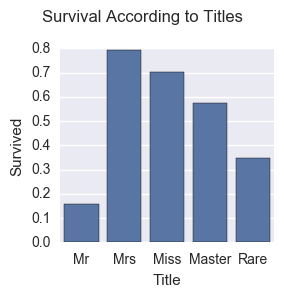

In [16]:
g = sns.FacetGrid(data, margin_titles = True)
g.map(sns.barplot,'Title','Survived',ci = None)
plt.subplots_adjust(top = 0.85)
g.fig.suptitle('Survival According to Titles')

So far, we know that females are the most likely to survive, so are younger passengers.
By combining 'Age' with the plot, we shall expect young females has a very high survival ratio.

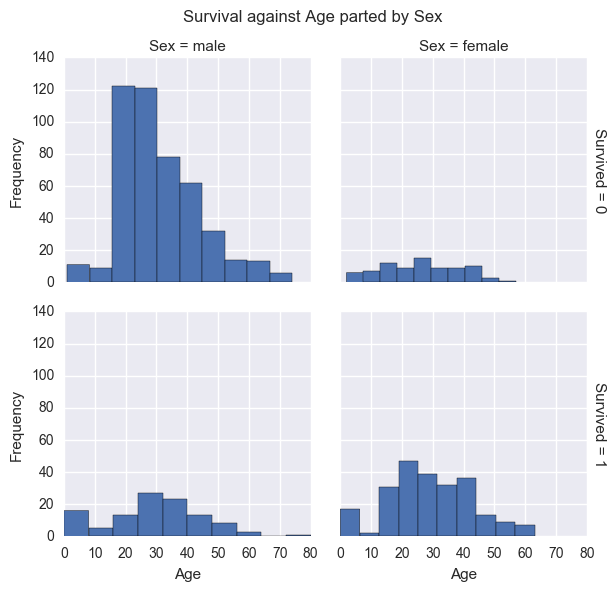

In [17]:
g = sns.FacetGrid(data, col = 'Sex', row = 'Survived', margin_titles = True)
(g.map(plt.hist,'Age').set_axis_labels('Age','Frequency'))
plt.subplots_adjust(top = 0.9)
g.fig.suptitle('Survival against Age parted by Sex')

### Family Size

Note that Family size has little correlation with survival.

Table shows that people with family gnerally has higher surivavl rate.
That being said, solo passengers are less likely to survive

In [18]:
data['FamSize'] = data['SibSp'] + data['Parch'] + 1
sur('FamSize','Survived')

,FamSize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


## (iii) Exploration

### Whare are some noteworthy variables?

Correlation plot allows us to see what may be interesting or important against each variable.  
Keep in mind that this correlation plot has yet to include categorical variables.

I can first simply numerize 'Sex' as it is probably an important factor.
As it will probably be used later, I numerize 'Embarked' as well.

In [19]:
data['MF'] = data['Sex'].map({'female' : 1 ,'male' : 0}).astype(int)
data['Embarkednum'] = data['Embarked'].map({'C' : 0, 'Q' : 1, 'S': 2})

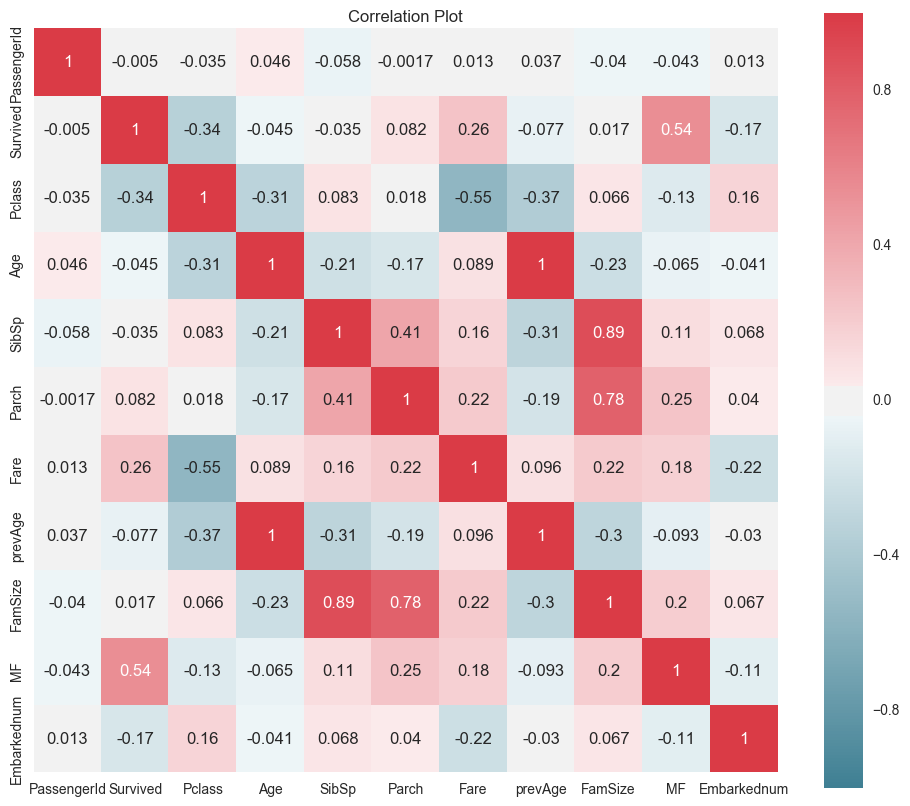

In [20]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = data.corr()
plt.figure(figsize = (12,10))
g = sns.heatmap(corr,cmap = cmap, annot = True, square = True , xticklabels = corr.columns.values, yticklabels = corr.columns.values)
plt.subplots_adjust(top = 0.9)
g.set_title('Correlation Plot')

### Age

Judging solely from the statistics below, we may assume younger passengers are more likely to survive.

In [21]:
data.groupby('Survived').Age.describe().unstack(level=0)

Survived,0,1
count,549.000000,342.000000
mean,30.183971,28.929825
std,13.139650,14.271592
min,1.000000,0.000000
25%,21.000000,20.000000
50%,28.000000,29.000000
75%,38.000000,38.750000
max,74.000000,80.000000



### Pclass

As one may have expected, the higher class that costs more are more likely to survive.

In [22]:
sur('Pclass', 'Survived')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Parch  

This does statistic may be deceving since only Parch = 1|2|3 has reasonable amount of inputs.  

While one might think solo-travellers are more likely to survive, this may prove not.

In [23]:
sur('Parch','Survived')

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [24]:
data.groupby(['Parch']).size()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
dtype: int64

### SibSp  
This statistic is quite similar to what we have with 'Parch'.

In [25]:
sur('SibSp', 'Survived')

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [26]:
data.groupby(['SibSp']).size()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

We will later further investigate with 'Parch' and 'SibSp' together.

### Embarked

This is very convincing that 'Embarked' = C is the most likely to survive.

In [27]:
sur('Embarked', 'Survived')

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [28]:
data.groupby(['Embarked']).size()

Embarked
C    168
Q     77
S    646
dtype: int64

### Fare

It seems to me that 'Fare' is a important factor to survival.  
With the correlation plot, it shows moderate positive correlation with Survived.
Pclass has a strong negative correlation with Fare, with upper class being the most expensive.  
Embarked also has a negative correlation with Fare.  

Hence, by cutting 'Fare' into quantiles, we see that the statistics agrees with our assumption.

In [29]:
data['qqFare'] = pd.qcut(data['Fare'],4)
sur('qqFare','Survived')

,qqFare,Survived
3,"(31, 512.329]",0.581081
2,"(14.454, 31]",0.454955
1,"(7.91, 14.454]",0.303571
0,"[0, 7.91]",0.197309


## (iv) Data visualization  

### To better understand the dataset, it will help to visualize it and possibly confirm observations above.

I plan to plot different variables against 'Survived' and possibly investigate further.  
As the correlation plot may suggest, we are interested in 'Pclass','Parch', and 'Fare'.

### Age

It is almsot a must to see the relationship between Age and Survived.  
We can see that the general shape is quite similar with a slight edge on younger passengers.  
That being said, this further proves that younger passengers are slightly more likely to survive.

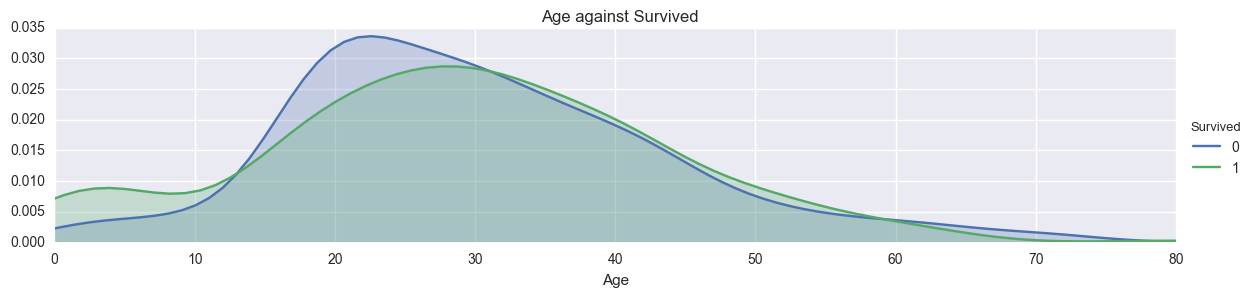

In [30]:
g = sns.FacetGrid(data, hue = 'Survived', aspect = 4)
g.map(sns.kdeplot, 'Age', shade = True)
g.set(xlim = (0,max(data['Age'])))
g.add_legend()
g.fig.suptitle('Age against Survived')

Looking merely at the age geature may not be enough, hence we now add Survied and Pclass features.

We can see that most of lower class did not survive, while middle class has about the equal amount of survival. These plots also support our brief observation that upper class are very likely to survive.
Further looking into Pclass relationship by adding Fare and Sex as features.

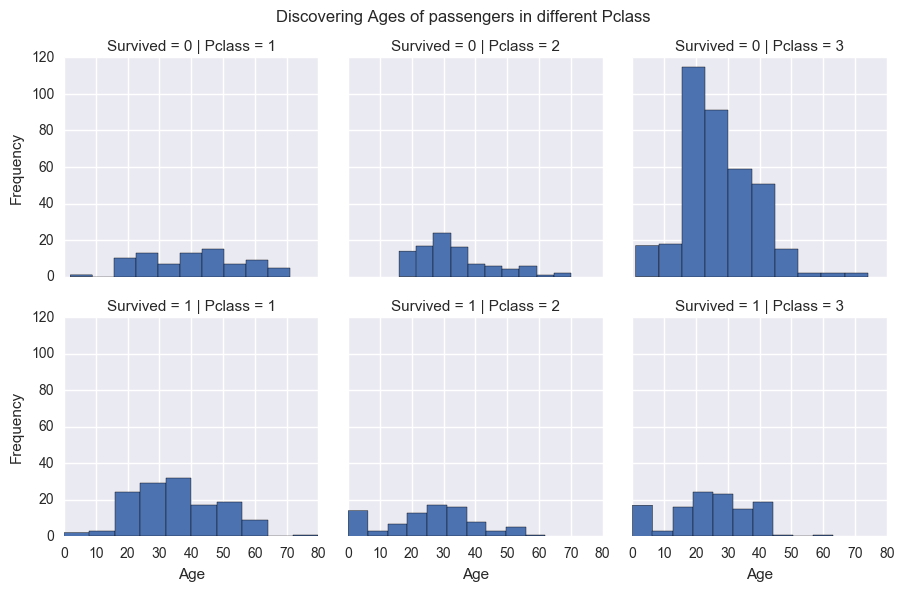

In [31]:
g = sns.FacetGrid(data, col = 'Pclass', row= 'Survived')
(g.map(plt.hist,'Age')).set_axis_labels('Age','Frequency')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Discovering Ages of passengers in different Pclass')

With the following violin plot, we can see the "Deceased" has a thicker end than the "Survived" as passengers are older.  
Comparing the distribution, we observer a significant difference at around age 10 and below; that being said, it is safe to say children are more likely to survive with respect to the population.

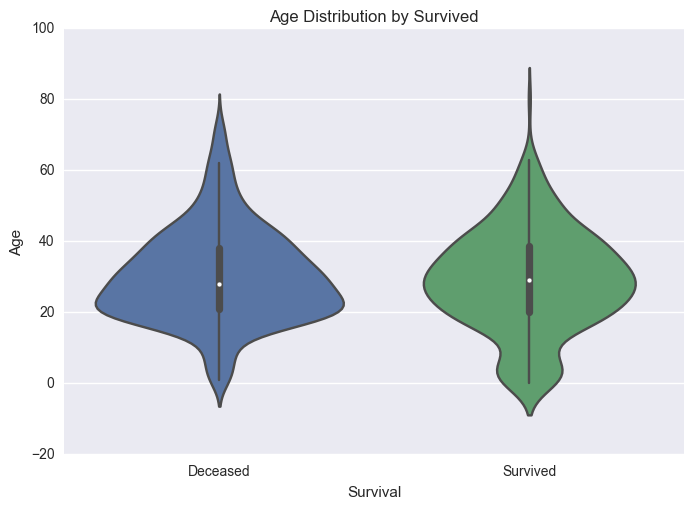

In [32]:
g = sns.violinplot(data = data , x = 'Survived', y = 'Age', order = [0,1])
g.set(title = 'Age Distribution by Survived', 
        xlabel = 'Survival', 
        ylabel = 'Age',
        xticklabels = ['Deceased','Survived'])
plt.figure(figsize = (8,10))

### Fare

While the following chart gives a good indicator on the price difference between Pclass.  
We can clearly see that upper class has the highest fare overall, and it also provides a higher survival rate as mentioned above.  
Please also take not of the huge jump of price for the upper class tickets.

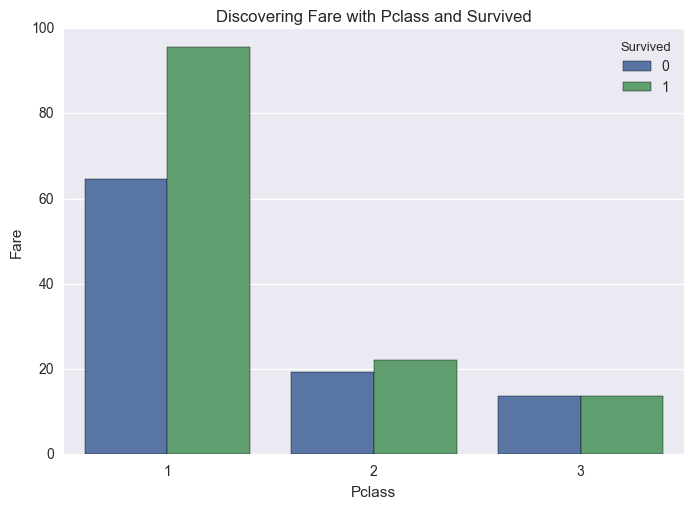

In [33]:
g = sns.barplot(data['Pclass'],data['Fare'],hue = data['Survived'],ci = None)
plt.subplots_adjust(top=0.9)
g.set(ylabel='Fare')
g.set_title('Discovering Fare with Pclass and Survived')

Please note that we use log scaling on Fare for its skewness.  
We can see that the more expensive seats has higher amount of survival.  This agrees with the idea that higher class would cost more which translates to higher survival chance.

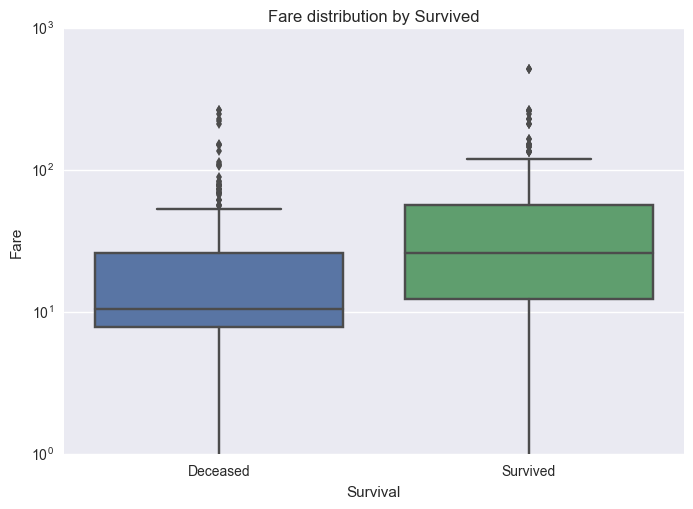

In [34]:
g=sns.boxplot(x=data['Survived'],y= data['Fare'])
g.set(title = 'Fare distribution by Survived',
      xlabel = 'Survival',
      xticklabels = ['Deceased','Survived'],
      yscale='log')
plt.figure(figsize = (8,10))

### Embarked

While investigating the Embarked feature, we can also throw in Sex to see more information.

Females are more likely to survived in general, while passengers from Cherbourg being an exception.

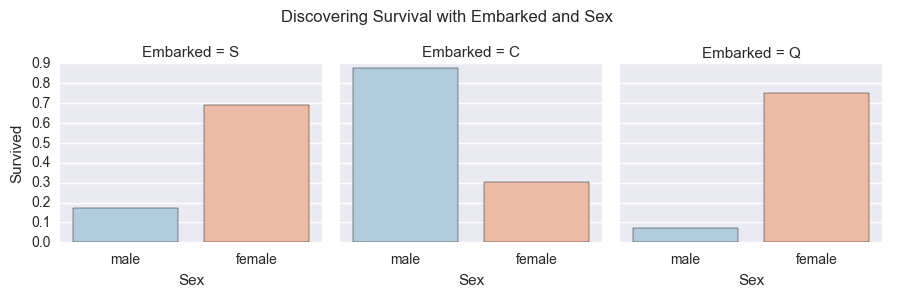

In [35]:
g = sns.FacetGrid(data,col  = 'Embarked')
g.map(sns.barplot,'Sex','Survived',ci = None,palette = 'RdBu_r')
g.add_legend()
plt.subplots_adjust(top = 0.8)
g.fig.suptitle('Discovering Survival with Embarked and Sex')

The following chart follows up with the one above but with a Pclass feature added.  
This would futher confirm that the higher the class, highest being upper class, has the highest survived.  
Also, from the bar plot we might consider Cherbourg passengers are more likely to survive.

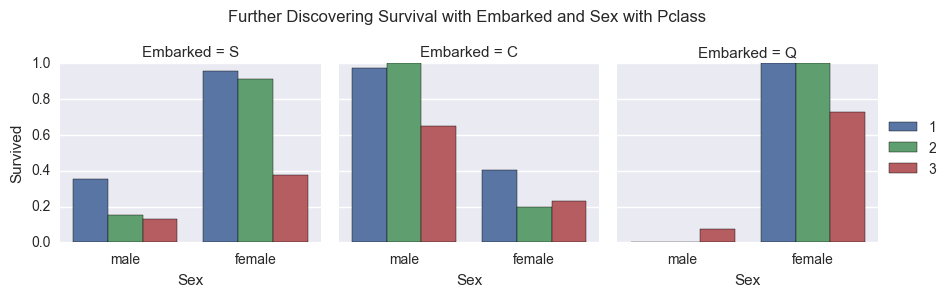

In [36]:
g = sns.FacetGrid(data,col  = 'Embarked')
g.map(sns.barplot,'Sex','Survived','Pclass', ci = None, palette = 'deep')
g.set(xlabel = 'Sex')
g.add_legend()
plt.subplots_adjust(top = 0.8)
g.fig.suptitle('Further Discovering Survival with Embarked and Sex with Pclass')

With this age distribution by Emabarkment, we see that Southampton has a older age distribution, notably with the highest age peak.  
While passengers from Cherbourg and Queenstown have notably lower age peak and also younger age group.

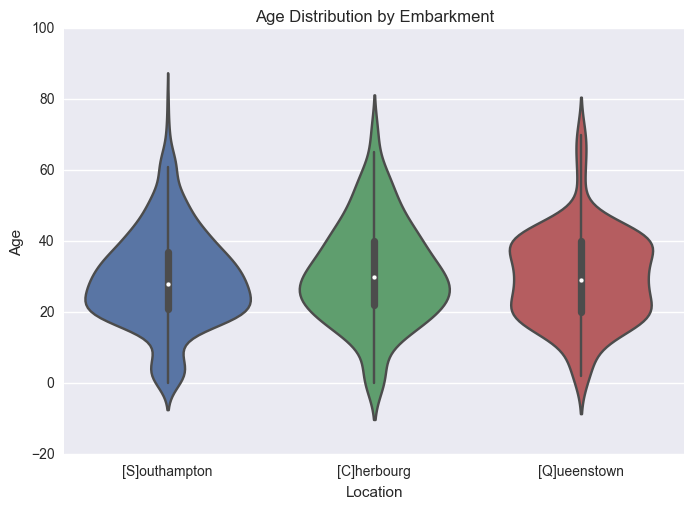

In [37]:
g = sns.violinplot(data = data , x = 'Embarked',y = 'Age',order=['S','C','Q'])
g.set(title = 'Age Distribution by Embarkment', 
        xlabel = 'Location', 
        ylabel = 'Age',
        xticklabels = ['[S]outhampton','[C]herbourg', '[Q]ueenstown'])
plt.figure(figsize = (12,14))

## (v) Statistical Inference

Here, we mainly use the Mann-Whitney rank test and the Chi-Square Independence test;  
Mann-Whitney rank test to compare survival rate on the same feature, and  
Chi-Square Independence test to check for independence against 'Survived'.  

### Validation for statistical tests assumptions
For Mann-Whitney rank test:
* One dependent variable - **Valid**: 'Survived'
* One independent variable that consists of two categorical, independent groups - **Valid**: 'Sex', etc.
* Observations are independent - **Valid**
* Distributions of scores from groups of independent variables can be determined. - **Valid**: 'Sex', etc.


For Chi-Square Independence test:
* Frequency in each cell is at least 5 - **Valid**
* Oberservations are independent - **Valid**
* Simple random sample - **Valid**: The dataset is the population.


### Sex
Females are more likely to survive than males;
there is sufficient evidence to conclude that 'Sex' and 'Survived' are related.

In [38]:
# Sex

# Null Hyp: Females more likely to survive than males
# Alt Hyp: Females is not more likley to survive than males
stat, p = stats.mannwhitneyu(x = data.loc[(data['MF'] == 1) , 'Survived'],
                  y = data.loc[(data['MF'] == 0), 'Survived'], alternative = 'less')
print('Null Hyp: Females are more likely to survive than males\
      \nAlt Hyp: Females is not more likley to survive than males')
msg = "Test Statistic: {}\np-value: {}"
print( msg.format( stat, p ) )
# Do not reject null hyp.

# Null Hyp: Sex and Survived are independent
# Alt Hyp: Sex and Survived are dependent
observed = pd.crosstab(data['Sex'],data['Survived'])
chi2, p, dof, expected = stats.chi2_contingency(observed = observed)
print('\nNull Hyp: Sex and Survived are independent\
      \nAlt Hyp: Sex and Survived are dependent')
print( msg.format( chi2, p ) )
# Reject null hyp.

Null Hyp: Females are more likely to survive than males      
Alt Hyp: Females is not more likley to survive than males
Test Statistic: 140696.5
p-value: 1.0

Null Hyp: Sex and Survived are independent      
Alt Hyp: Sex and Survived are dependent
Test Statistic: 260.717020167
p-value: 1.19735706278e-58


### Pclass
Upper class is not as likely to survive compared to the population.  
In fact, passengers with upper class are more likely to survive than the population.  
There is also sufficient evidence to conclude that 'Pclass' and 'Survived' are related.

In [39]:
# Pclass

# Null Hyp: Upper class is as likley to survive as the population
# Alt Hyp: Upper class is not as likely to survive as the population
stat, p = stats.mannwhitneyu(x = data.loc[(data['Pclass'] == 1) , 'Survived'],
                  y = data['Survived'], alternative = 'two-sided')
print('Null Hyp: Upper class is as likley to survive as the population\
      \nAlt Hyp: Upper class is not as likely to survive as the population')
print( msg.format( stat, p ) )
# Reject null hyp.

# Null Hyp: Upper class is more likely to survive than the population
# Alt Hyp: Upper class is not more likely to survive than the population
stat, p = stats.mannwhitneyu(x = data.loc[(data['Pclass'] == 1) , 'Survived'],
                  y = data['Survived'], alternative = 'less')

print('\nNull Hyp: Upper class is more likely to survive than the population\
      \nAlt Hyp: Upper class is not more likely to survive than the population')
print( msg.format( stat, p ) )
# Do not reject null hyp.

# Null Hyp: Pclass and Survived are independent
# Alt Hyp: Pclass and Survived are dependent
observed = pd.crosstab(data['Pclass'],data['Survived'])
chi2, p, dof, expected = stats.chi2_contingency(observed = observed)
print('\nNull Hyp: Pclass and Survived are independent\
      Alt Hyp: Pclass and Survived are dependent')
print( msg.format( chi2, p ) )
# Reject null hyp.

# Fare and Pclass
# Null Hyp: Fare and Pclass are independent
# Alt Hyp: Fare and Pclass are dependent
observed = pd.crosstab(data['Fare'],data['Pclass'])
chi2, p, dof, expected = stats.chi2_contingency(observed = observed)
print('\nNull Hyp: Fare and Pclass are independent\
      \nAlt Hyp: Fare and Pclass are dependent')
print( msg.format( chi2, p ) )
# Recjet null hyp.

Null Hyp: Upper class is as likley to survive as the population      
Alt Hyp: Upper class is not as likely to survive as the population
Test Statistic: 119880.0
p-value: 6.16211125907e-11

Null Hyp: Upper class is more likely to survive than the population      
Alt Hyp: Upper class is not more likely to survive than the population
Test Statistic: 119880.0
p-value: 0.999999999969

Null Hyp: Pclass and Survived are independent      Alt Hyp: Pclass and Survived are dependent
Test Statistic: 102.888988757
p-value: 4.5492517113e-23

Null Hyp: Fare and Pclass are independent      
Alt Hyp: Fare and Pclass are dependent
Test Statistic: 1697.83431564
p-value: 1.09861666791e-131


### Embarked

Among the features we looked at, 'Embarked' seem to be the harder one to conclude.  

However, with the statiscal tests, it is clear that there is enough evidence to conclude that Passengers from Cherbourg are more likely to survive than the population.
Also, there appears to have enough evidence to show that 'Embarked' and 'Survived' are related.

In [40]:
#Embarked

# Null Hyp: Passengers from Cherbourg are more likely to survive than the population
# Alt Hyp: Passengers from Cherbourg are not more likely to survive than the population
stat, p = stats.mannwhitneyu(x = data.loc[(data['Embarked'] == 'C') , 'Survived'],
                  y = data['Survived'], alternative = 'less')
print('Null Hyp: Passengers from Cherbourg are more likely to survive than the population\
      \nAlt Hyp: Passengers from Cherbourg are not more likely to survive than the population')
print( msg.format( stat, p ) )
# Reject null hyp.

# Null Hyp: Embarked and Survived are independent
# Alt Hyp: Embarked and Survived are dependent
observed = pd.crosstab(data['Embarked'],data['Survived'])
chi2, p, dof, expected = stats.chi2_contingency(observed = observed)
print('\nNull Hyp: Embarked and Survived are independent\
      \nAlt Hyp: Embarked and Survived are dependent')
print( msg.format( chi2, p ) )
# Reject null hyp.

Null Hyp: Passengers from Cherbourg are more likely to survive than the population      
Alt Hyp: Passengers from Cherbourg are not more likely to survive than the population
Test Statistic: 87547.5
p-value: 0.999979341686

Null Hyp: Embarked and Survived are independent      
Alt Hyp: Embarked and Survived are dependent
Test Statistic: 25.9644528819
p-value: 2.30086264814e-06


### Family Size

Here, we look at the significance of survival between solo passengers and passengers with family.  
We may conclude that passengers travelling with family are more likely to survive.  

As a side note,this conclusion might be due to the idea that people tend to prioritze on saving women and children first which agrees with the higher survival rate on children and women.  

There is also enough evidence to conclude that family size and survived are dependent.

In [41]:
# Family Size

# Null Hyp: Solo Passengers are less likely to survive compared to passengers travelling with family
# Alt Hyp: Solo Passengers are not less likely to survive compared to passengers travelling with family
stat, p = stats.mannwhitneyu(x = data.loc[(data['FamSize'] == 1) , 'Survived'],
                  y = data.loc[(data['FamSize'] != 1), 'Survived'], alternative = 'greater')
print('Null Hyp: Solo passengers are less likely to survive compared to passengers travelling with family\
      \nAlt Hyp: Solo Passengers are not less likely to survive compared to passengers travelling with family')
print( msg.format( stat, p ) )
# Do not reject null hyp.

# Null Hyp: Family Size and Survived are independent
# Alt Hyp: Family Size and Survived are dependent
observed = pd.crosstab(data['FamSize'],data['Survived'])
chi2, p, dof, expected = stats.chi2_contingency(observed = observed)
print('\nNull Hyp: Family Size and Survived are independent\
      \nAlt Hyp: Family Size and Survived are dependent')
print( msg.format( chi2, p ) )
# Recjet null hyp.

Null Hyp: Solo passengers are less likely to survive compared to passengers travelling with family      
Alt Hyp: Solo Passengers are not less likely to survive compared to passengers travelling with family
Test Statistic: 75838.5
p-value: 0.999999999349

Null Hyp: Family Size and Survived are independent      
Alt Hyp: Family Size and Survived are dependent
Test Statistic: 80.6723134378
p-value: 3.57966897544e-14


## Conclusions

### Findings
We can conclude that passengers with the following characteristic are more likely to survive:
* Female
* Children
* With family
* Upper class (higher fare)
* From Cherbourg  

As mentioned, passengers who are **female or children** are more likely to survive with the reason being the general practice of saving women and children first.  
Solo passengers might just be less likely to survive due to the lack of assistance compared to ones with **family** memebers aboard.  
**Higher fare** clearly implies **upper class**, thus higher survival rate possibly due to the equipment provided or location.  
While everything above makes sense, it is very interesting that passengers **from Cherbourg** are more likely to survive compared to other embarkments. Putting more thoughts into peculiar occurance, one might suggest seats are assigned according to embarkments and that Cherbourg passengers happened to be in a better position during the incident.  

### Limitations
1. This data set is only roughly 40% of the dataset, 891 of 2224 passengers. If the sample is not randomly drawn from the population, findings can be inaccurate.  
2. Note that we also disregarded the Cabin feature by dropping if due to the amount of missing values. If possible, one may try to include the feature to have better findings since it is likely that the Cabin feature may closely correlate to Survival rate, similar to Pclass.  
3. While the age prediction was proved to be sufficiently accurate, one may also consider using other features, such as Pclass and Sex, for guessing.  
4. There may be a survival bias, meaning there is more data on surivors within the dataset.  
5. Sibsp and Parch, hence FamSize, may not be accurate since some family relations could have been ignored.  
6. This data analysis is only limited to exploring correlations but not causation; if we were to investigate on causation, multiple controlled experiments may be needed.

### Further possible explorations

There are definitely several more explorations that can be done with the dropped features, namely 'Cabin' and 'Ticket'.  
These features may provide an exact location of passengers that could possibly solve the mystery of the high survival rate on Cherbourg passengers and may provide more interesting findings.  

## Reference

https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier  
https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php  
https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Assumptions